# 1. Tải bộ dữ liệu

In [1]:
!gdown 1dANzxlEjeCEbveFOWWqzSG-niVx-vCgK

Downloading...
From: https://drive.google.com/uc?id=1dANzxlEjeCEbveFOWWqzSG-niVx-vCgK
To: /content/sentiment_analysis.csv
100% 1.10M/1.10M [00:00<00:00, 44.5MB/s]


# 2. Import libraries

In [2]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from nltk.tokenize import TweetTokenizer
from collections import defaultdict

# 3. Đọc bộ dữ liệu

In [3]:
dataset_path = '/content/sentiment_analysis.csv'
df = pd.read_csv(dataset_path,
                 index_col='id')
df.head()

,label,tweet
id,,
1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...
2,0,Finally a transparant silicon case ^^ Thanks t...
3,0,We love this! Would you go? #talk #makememorie...
4,0,I'm wired I know I'm George I was made that wa...
5,1,What amazing service! Apple won't even talk to...


# 4. Tiền xử lý bộ dữ liệu

## 4a Xây dựng hàm chuẩn hóa văn bản:

In [4]:
def text_normalize(text):
  # Retweet old acronym "RT" removal
  text = re.sub(r'^RT[\s]+', '', text)

  # Hyperlinks removal
  text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)

  # Hashtag removal
  text = re.sub(r'#', '', text)

  # Punctuation removal
  text = re.sub(r'[^\w\s]', '', text)

  # Tokenization
  tokenizer = TweetTokenizer(
      preserve_case=False,
      strip_handles=True,
      reduce_len=True
  )
  text_tokens = tokenizer.tokenize(text)

  return text_tokens

## 4b Xây dựng bộ lưu giữ tần suất xuất hiện của các từ

In [5]:
def get_freqs(df):
  freqs = defaultdict(lambda: 0)
  for idx, row in df.iterrows():
    tweet = row['tweet']
    label = row['label']

    tokens = text_normalize(tweet)
    for token in tokens:
      pair = (token, label)
      freqs[pair] += 1
  return freqs

## 4c Xây dựng hàm tạo vector đặc trưng:

In [6]:
def get_feature(text, freqs):
  tokens = text_normalize(text)

  X = np.zeros(3)
  X[0] = 1

  for token in tokens:
    X[1] += freqs[(token, 0)]
    X[2] += freqs[(token, 1)]

  return X

## 4d Trích xuất đặc trưng toàn bộ dữ liệu:

In [7]:
X = []
y = []

freqs = get_freqs(df)
for idx, row in df.iterrows():
  tweet = row['tweet']
  label = row['label']

  X_i = get_feature(tweet, freqs)
  X.append(X_i)
  y.append(label)

X = np.array(X)
y = np.array(y)

In [8]:
freqs

defaultdict(<function __main__.get_freqs.<locals>.<lambda>()>,
            {('fingerprint', 0): 4,
             ('pregnancy', 0): 1,
             ('test', 0): 8,
             ('finally', 0): 168,
             ('a', 0): 727,
             ('transparant', 0): 1,
             ('silicon', 0): 1,
             ('case', 0): 228,
             ('thanks', 0): 94,
             ('to', 0): 876,
             ('my', 0): 1227,
             ('uncle', 0): 4,
             ('yay', 0): 63,
             ('sony', 0): 701,
             ('xperia', 0): 54,
             ('s', 0): 38,
             ('sonyexperias', 0): 1,
             ('we', 0): 159,
             ('love', 0): 385,
             ('this', 0): 456,
             ('would', 0): 95,
             ('you', 0): 557,
             ('go', 0): 67,
             ('talk', 0): 12,
             ('makememories', 0): 1,
             ('unplug', 0): 2,
             ('relax', 0): 31,
             ('iphone', 0): 2905,
             ('smartphone', 0): 61,
             ('wifi',

In [9]:
X, y

(array([[1.000e+00, 1.300e+01, 2.000e+00],
        [1.000e+00, 4.183e+03, 2.788e+03],
        [1.000e+00, 4.768e+03, 1.425e+03],
        ...,
        [1.000e+00, 6.175e+03, 4.635e+03],
        [1.000e+00, 3.814e+03, 1.959e+03],
        [1.000e+00, 6.160e+03, 3.181e+03]]),
 array([0, 0, 0, ..., 0, 0, 0]))

# 5. Chia bộ train, val, test:

In [10]:
val_size = 0.2
test_size = 0.125
random_state = 2
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                    test_size=val_size,
                                                    random_state=random_state,
                                                    shuffle=is_shuffle)

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train,
                                                    test_size=test_size,
                                                    random_state=random_state,
                                                    shuffle=is_shuffle)

# 6. Chuẩn hóa dữ liệu

In [11]:
nomalizer = StandardScaler()
X_train[:, 1:] = nomalizer.fit_transform(X_train[:, 1:])
X_val[:, 1:] = nomalizer.transform(X_val[:, 1:])
X_test[:, 1:] = nomalizer.transform(X_test[:, 1:])

# 7. Cài đặt các hàm quan trọng:

In [40]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def compute_loss(y_hat, y):
    y_hat = np.clip(y_hat, 1e-7, 1 - 1e-7)
    return (-y * np.log(y_hat) - (1 - y) * np.log(1 - y_hat)).mean()

def predict(X, theta):
    dot_product = np.dot(X, theta)
    y_hat = sigmoid(dot_product)
    return y_hat

def compute_gradient(X, y, y_hat):
    return np.dot(X.T, (y_hat - y)) / y.size

def update_theta(theta, gradient, lr):
    return theta - lr * gradient

# def compute_accuracy(X, y, theta):
#     y_hat = predict(X, theta).round()
#     acc = (y_hat == y).mean()
#     return acc

def compute_accuracy(y, y_pred):
  y_pred = np.where(y_pred > 0.5, 1, 0)
  return np.mean(y_pred == y)

# 8. Khai báo các siêu tham số và khởi tạo weights:

In [41]:
lr = 0.01
NUM_EPOCHS = 200
batch_size = 128

np.random.seed(random_state)
theta = np.random.uniform(size=X_train.shape[1])

# 9. Huấn luyện mô hình:

In [42]:
train_accs = []
train_losses = []
val_accs = []
val_losses = []
NUM_EPOCHS = 200
learning_rate = 0.01
batch_size = 128
np.random.seed(2)
theta = np.random.randn(X_train.shape[1])
for e in range(NUM_EPOCHS):
  train_batch_losses, train_batch_accs = [], []
  val_batch_losses, val_batch_accs = [], []

  for i in range(0, X_train.shape[0], batch_size):
    X, y = X_train[i:i+batch_size], y_train[i:i+batch_size]
    y_pred = predict(X, theta)
    loss = compute_loss(y, y_pred)
    grad = compute_gradient(X, y, y_pred)
    theta = update_theta(theta, grad, learning_rate)

    acc = compute_accuracy(y, y_pred)

    train_batch_losses.append(loss)
    train_batch_accs.append(acc)

    y_val_pred = predict(X_val, theta)
    val_loss = compute_loss(y_val, y_val_pred)
    val_acc = compute_accuracy(y_val, y_val_pred)

  train_losses.append(np.mean(train_batch_losses))
  train_accs.append(np.mean(train_batch_accs))
  val_losses.append(val_loss)
  val_accs.append(val_acc)
  print(f'Epoch {e+1}/{NUM_EPOCHS} | Train Loss: {train_losses[-1]:.2f} | Train Acc: {train_accs[-1]:.2f} | Val Loss: {val_losses[-1]:.2f} | Val Acc: {val_accs[-1]:.2f}')

Epoch 1/200 | Train Loss: 9.94 | Train Acc: 0.33 | Val Loss: 9.76 | Val Acc: 0.31
Epoch 2/200 | Train Loss: 9.56 | Train Acc: 0.33 | Val Loss: 9.35 | Val Acc: 0.34
Epoch 3/200 | Train Loss: 9.13 | Train Acc: 0.36 | Val Loss: 8.92 | Val Acc: 0.38
Epoch 4/200 | Train Loss: 8.71 | Train Acc: 0.41 | Val Loss: 8.51 | Val Acc: 0.45
Epoch 5/200 | Train Loss: 8.31 | Train Acc: 0.48 | Val Loss: 8.13 | Val Acc: 0.56
Epoch 6/200 | Train Loss: 7.95 | Train Acc: 0.62 | Val Loss: 7.80 | Val Acc: 0.67
Epoch 7/200 | Train Loss: 7.63 | Train Acc: 0.70 | Val Loss: 7.51 | Val Acc: 0.70
Epoch 8/200 | Train Loss: 7.36 | Train Acc: 0.70 | Val Loss: 7.26 | Val Acc: 0.70
Epoch 9/200 | Train Loss: 7.13 | Train Acc: 0.70 | Val Loss: 7.04 | Val Acc: 0.70
Epoch 10/200 | Train Loss: 6.93 | Train Acc: 0.70 | Val Loss: 6.85 | Val Acc: 0.70
Epoch 11/200 | Train Loss: 6.75 | Train Acc: 0.70 | Val Loss: 6.69 | Val Acc: 0.70
Epoch 12/200 | Train Loss: 6.60 | Train Acc: 0.70 | Val Loss: 6.54 | Val Acc: 0.70
Epoch 13/200 

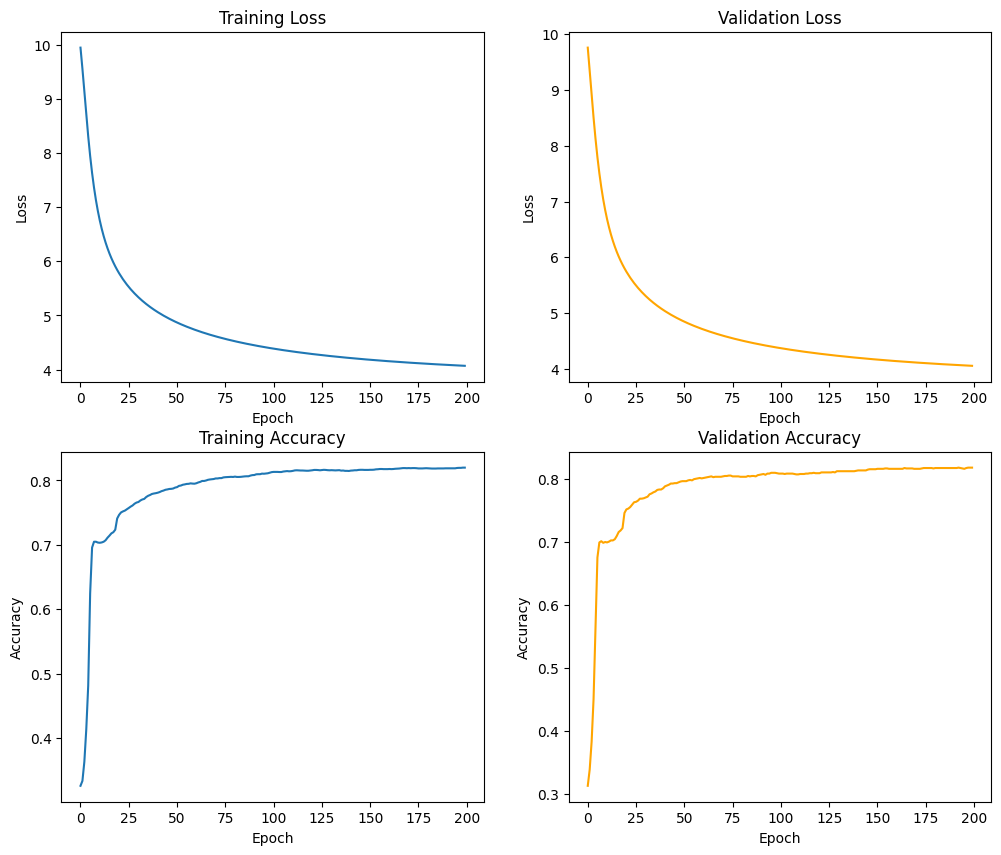

In [34]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_losses)
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_losses, 'orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_accs)
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_accs, 'orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

# 10. Đánh giá mô hình

In [36]:
val_acc = compute_accuracy(y_val, y_val_pred)
test_acc = compute_accuracy(y_test, predict(X_test, theta))
print('Evaluation on validation and test set:')
print(f'Accuracy (Validation Set): {val_acc:.2f}')
print(f'Test Accuracy: {test_acc:.2f}')

Evaluation on validation and test set:
Accuracy (Validation Set): 0.82
Test Accuracy: 0.84
